 ## <center> Naive Bayes Classifier </center>

El teorema de Bayes es una ecuación que describe **la relación de probabilidades condicionales de cantidades estadísticas**.

En clasificación bayesiana estamos interesados en encontrar la probabilidad de que ocurra una “clase” dadas unas características observadas (datos). Lo podemos escribir como **P( Clase | Datos)**. El teorema de Bayes nos dice cómo lo podemos expresar en términos de cantidades que podemos calcular directamente:

<h1> 
    $$ \frac {P(Comprar|Datos)}
        {P(Alquilar|Datos)}
                = \frac{P(Datos|Comprar) * P(Comprar)}
                                     {P(Datos|Alquilar) * P(Alquilar)}$$</h1>

con esta maniobra, nos deshacemos del denominador de la ecuación anterior P(Datos) el llamado “probabilidad marginal”. 

<h1>
    $$posterior(comprar) 
                = \frac{P(comprar)p(lngresos|comprar)p(ahorros|comprar)p(hijos|comprar)}
                                        {probabilidadmarginal}$$</h1>

<h1>
    $$posterior(alquilar) 
                =\frac{P(alquilar)p(lngresos|alquilar)p(ahorros|alquilar)p(hijos|alquilar)}
                                        {probabilidad marginal}$$</h1>

Posterior de comprar es lo que queremos hallar: P(comprar|datos).

 ## <center> Ejercicio Machine Learning: Gaussian Naive Bayes </center>

Alumna: Julissa M. Carballo Pinto.

## ¿Comprar o alquilar casa? ¿Qué me conviene?

En este ejercicio, usaremos el algoritmo de Gaussian Naive Bayes para decidir si nos conviene Alguilar o Comprar una casa 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

## Importemos Datos de entrada

REFERENCIAS: 

Ingresos y gastos son mensuales de 1 personas o 2 si están casados.

Trabajo: 
0-sin trabajo 
1-autonomo, 
2-asalariado, 
3-empresario, 
4-Autonomos, 
5-Asalariados, 
6-Autonomo y Asalariado, 
7-Empresario y Autonomo, 
8-Empresarios o empresario y autónomo.

Estado_civil: 0-soltero 1-casado 2-divorciado

Hijos: Cantidad de hijos menores (no trabajan)

Comprar: 0-mejor alquilar 1-Comprar casa.

Hipoteca fija a 30 años con interes.

In [2]:
dataframe = pd.read_csv(r"comprar_alquilar.csv")
dataframe.head(10)


,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


*cantidad de muestras de comprar o alquilar tenemos:*

In [3]:
print(dataframe.groupby('comprar').size())

comprar
0    135
1     67
dtype: int64


*histograma de las características quitando la columna de resultados (comprar):*

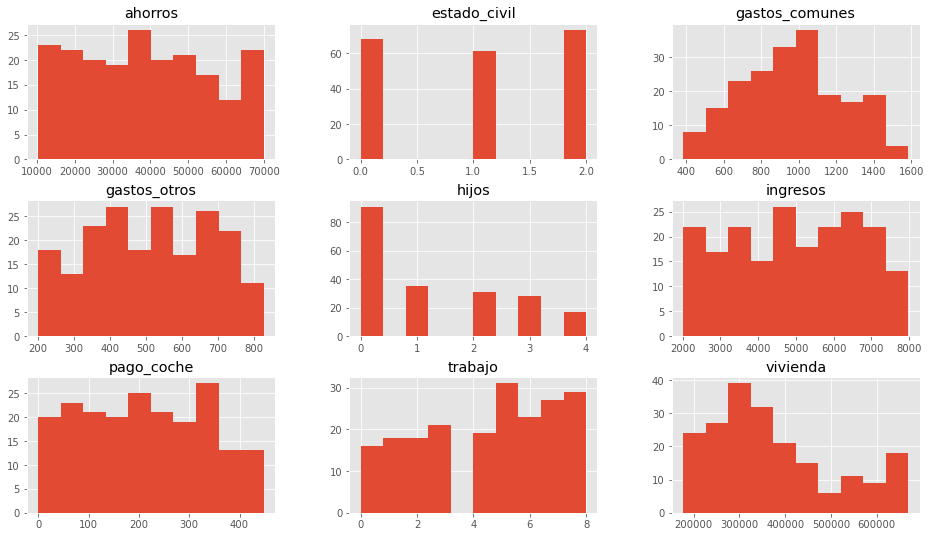

In [4]:
dataframe.drop(['comprar'], axis=1).hist()
plt.show()

# Preprocesamos los datos

Creamos 2 columnas nuevas. En una agrupamos:

-los gastos mensuales 

-el monto a financiar para comprar la casa

In [5]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1).head(10)

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,50000,400000,0,2,2,1,1600,350000
1,6745,43240,636897,1,3,6,0,1496,593657
2,6455,57463,321779,2,1,8,1,1926,264316
3,7098,54506,660933,0,0,3,0,1547,606427
4,6167,41512,348932,0,0,3,1,1606,307420
5,5692,50875,360863,1,4,5,1,1247,309988
6,6830,46761,429812,1,1,5,1,1952,383051
7,6470,57439,606291,0,0,1,0,1856,548852
8,6251,50503,291010,0,0,3,1,2030,240507
9,6987,40611,324098,2,1,7,1,1755,283487


### Información estadística de los datos

In [6]:
reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1)
reduced.describe()

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


## Feature Selection
Selección de las características de entrada.

### Veamos la correlación entre columnas

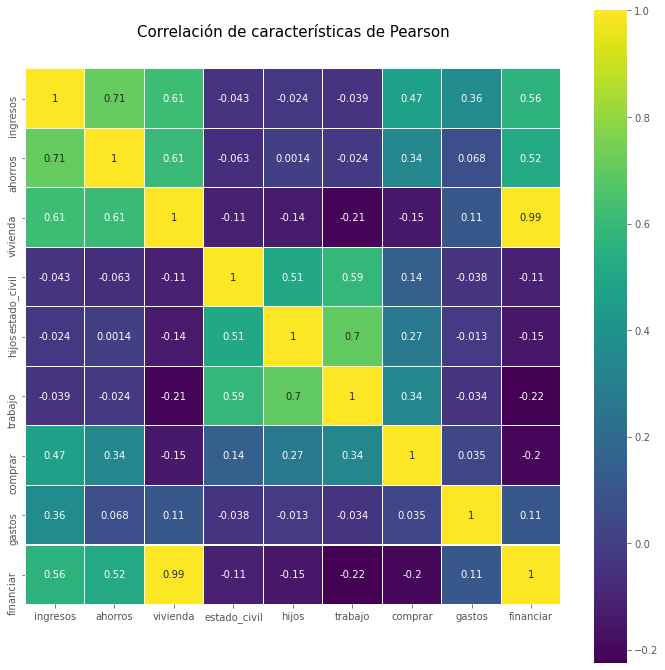

In [7]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlación de características de Pearson', y=1.05, size=15)
sb.heatmap(reduced.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Usemos la clase SelectKBest de SkLearn para elegir las 5 mejores características a usar.

In [8]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar'], dtype='object')


Veamos la correlación entre las 5 mejores Features

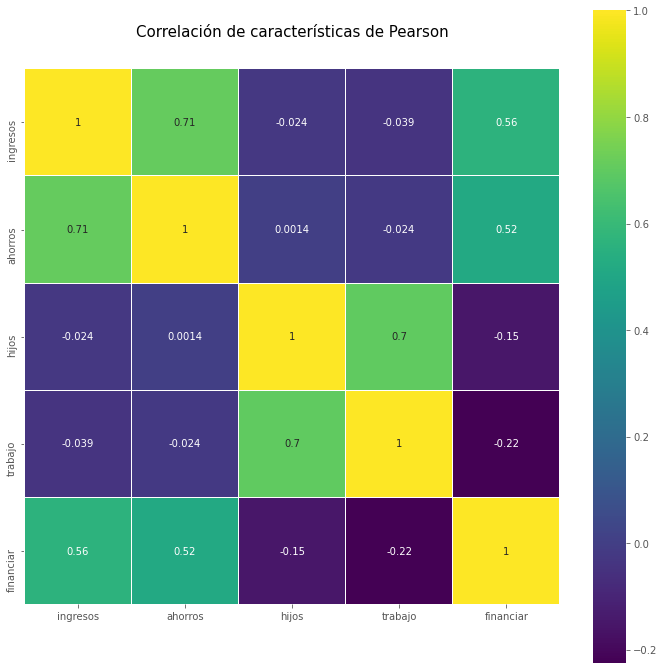

In [9]:
used_features =X.columns[selected]

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlación de características de Pearson', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

C:\Users\Julissa\anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


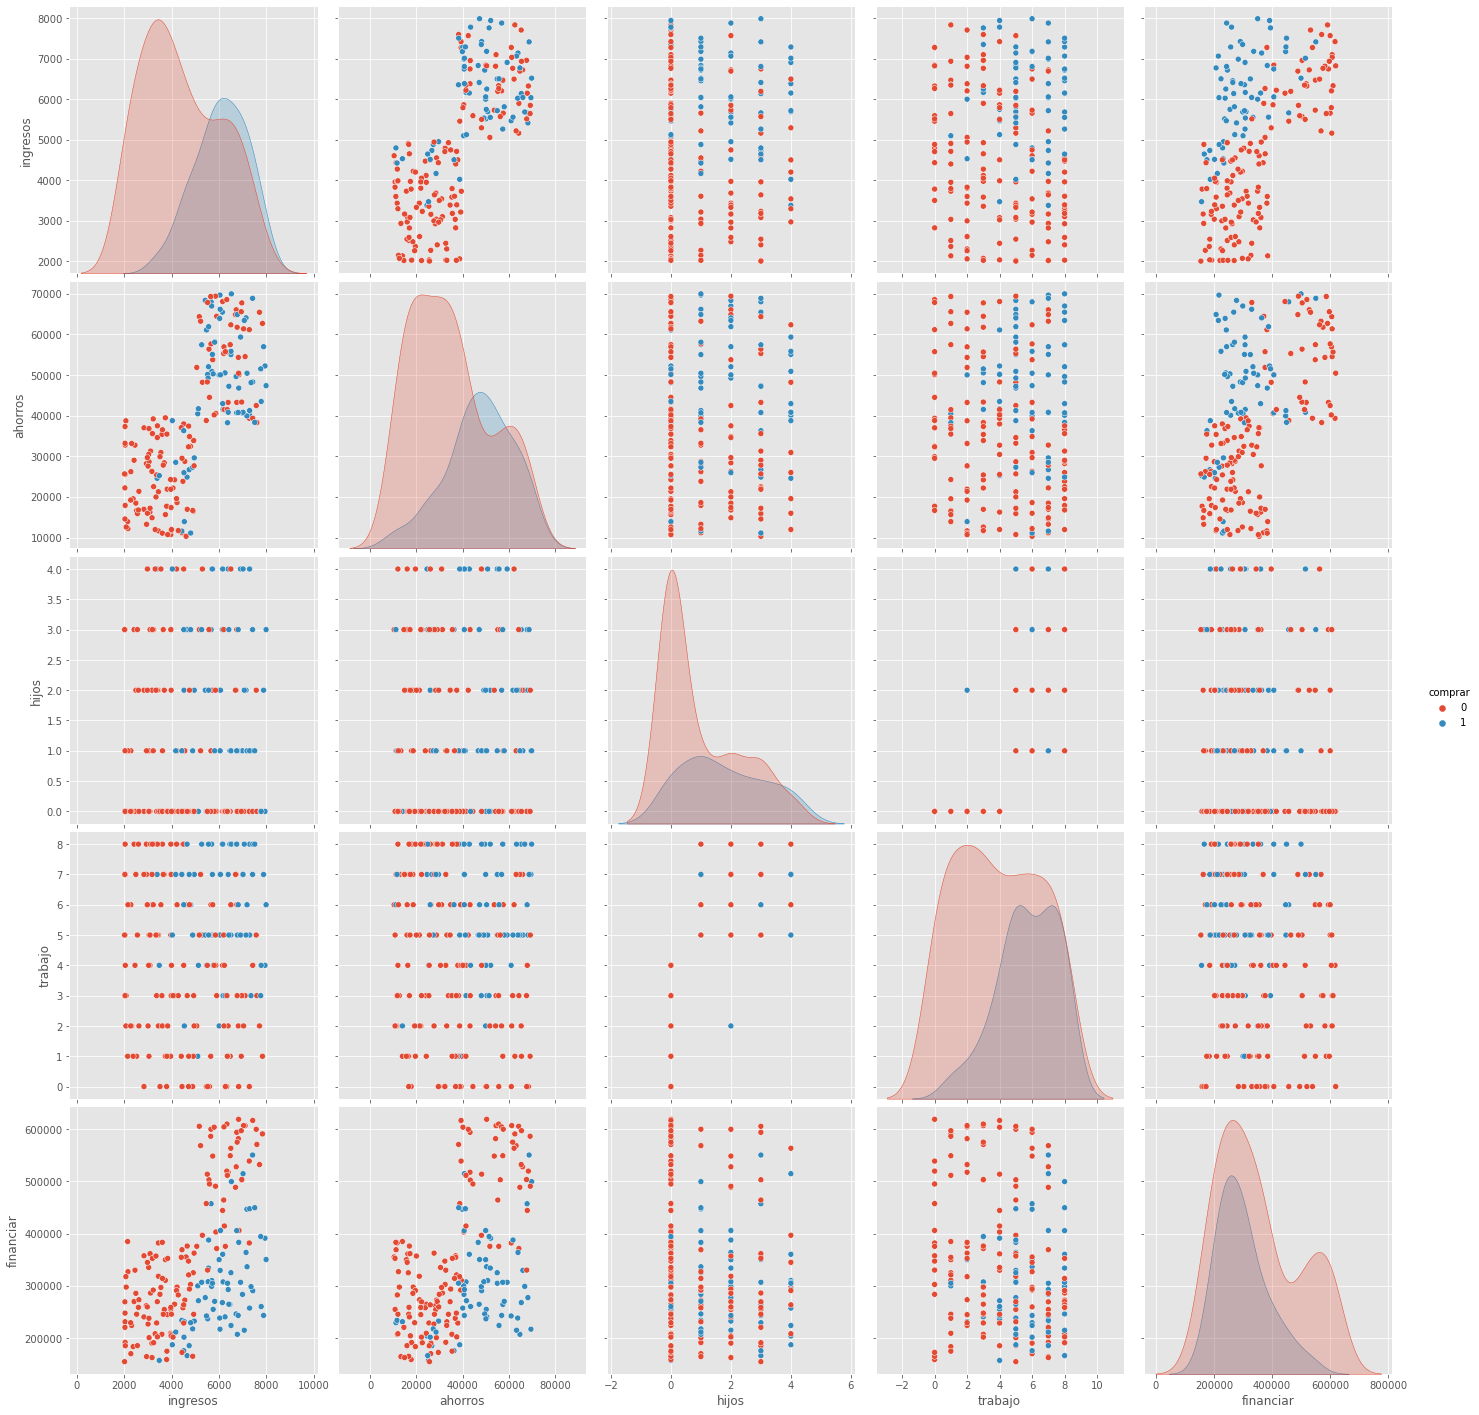

In [10]:
sb.pairplot(dataframe, hue='comprar',size=4,vars=used_features,kind='scatter')

# Creamos el modelo de Gaussian Naive Bayes

Dividimos en un set de Entrenamiento y otro de Test con el 20% de las entradas

In [11]:
# Split dataset in training and test datasets
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=10) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]

Entrenamos el modelo

In [12]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])

# Resultados

In [13]:
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test))) 

Precisión en el set de Entrenamiento: 0.87
Precisión en el set de Test: 0.88


In [14]:
# Print Test results
print("Total de Muestras en Test: {}\nFallos: {}"
      .format(
          X_test.shape[0],
          (y_test != y_pred).sum()
))

Total de Muestras en Test: 41
Fallos: 5


In [15]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[24  2]
 [ 3 12]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.86      0.80      0.83        15

    accuracy                           0.88        41
   macro avg       0.87      0.86      0.87        41
weighted avg       0.88      0.88      0.88        41



## Nuevas Predicciones

Hagamos 2 pruebas a modo de ejemplo en las que el algoritmo nos recomienda Alquilar (0) y Comprar (1) en el 2do caso

+ En un caso será una familia sin hijos con 2000  de ingresos que quiere comprar una casa de 200000 y tiene sólo 5000 ahorrados.
+ El otro será una familia con 2 hijos con ingresos por 6000 al mes, 34000 en ahorros y consultan si comprar una casa de 320000.

In [16]:
#                 ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[2000,        5000,     0,       5,         200000],
                   [6000,        34000,    2,       5,         320000] ]))
#Resultado esperado 0-Alquilar, 1-Comprar casa

[0 1]


Los resultados son los esperados, en el primer caso, recomienda Alquilar (0) y en el segundo comprar la casa (1).

**EJERCICIO RESOLVER COMO EJEMPLO** 

+ Caso 1: una familia con **5** hijos con 10000  de ingresos que quiere comprar una casa de 500000 y tiene sólo 20000 ahorrados.
+ Caso 2: una familia con **1** hijo con ingresos de 8000 al mes, 60000 en ahorros y consultan si comprar una casa de 100000 
+ Caso 3: una familia **sin** hijo con ingresos de 15000 al mes, 40000 en ahorros y consultan si comprar una casa de 150000

In [17]:
#                 ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[10000,        20000,     5,       5,         500000],
                   [8000,         60000,     1,       5,         100000],
                   [15000,        40000,      0,      4,         150000]]))
#Resultado esperado 0-Alquilar, 1-Comprar casa

[0 1 0]
